In [1]:
from tams_pr2_guzheng.paths import RuckigPath
from tams_pr2_guzheng.onset_to_path import OnsetToPath
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import scipy.stats as stats
import seaborn as sns
import sklearn.gaussian_process as gp

In [2]:
%load_ext autoreload
%autoreload 1
import sys
if 'utils' not in sys.path:
    sys.path.append('utils')
import u
%aimport u

In [3]:
p= RuckigPath.random(string = 'fis3', string_position= 0.05)

In [4]:
o2p= OnsetToPath()

In [5]:
D = []
for d in np.linspace(0.0, 0.012, 100):
    D.append({'min_distance': d, 'loudness': 40.0, 'unexpected_onsets': 0})
df = pd.DataFrame(D)
df

,min_distance,loudness,unexpected_onsets
0,0.000000,40.0,0
1,0.000121,40.0,0
2,0.000242,40.0,0
3,0.000364,40.0,0
4,0.000485,40.0,0
...,...,...,...
95,0.011515,40.0,0
96,0.011636,40.0,0
97,0.011758,40.0,0
98,0.011879,40.0,0


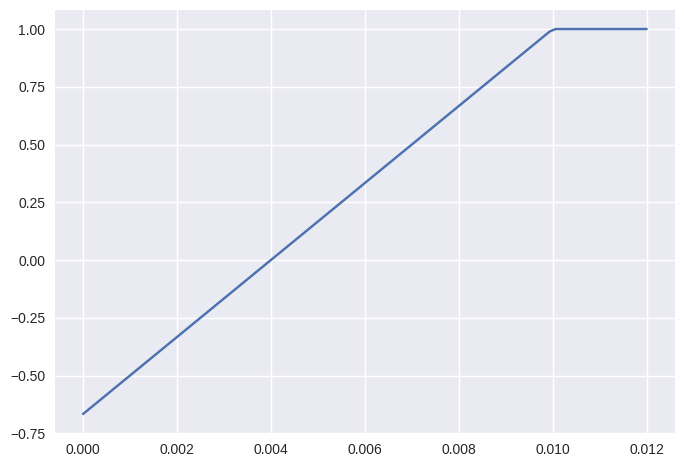

In [8]:
plt.plot(df['min_distance'], o2p.score(df));

In [40]:
sampler = lambda d= stats.qmc.Halton(d=2, seed = 37): d.random()

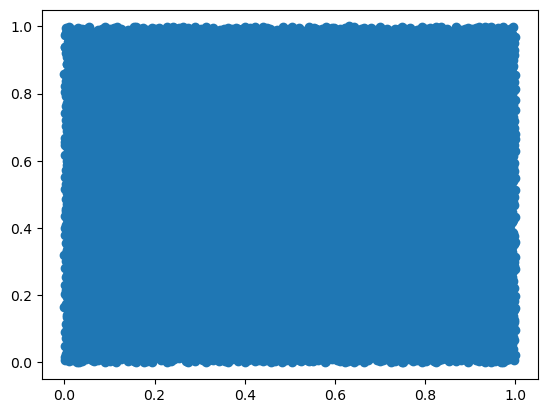

In [42]:
N=10000
D=np.zeros((N,2))
for i in range(N):
    D[i,:]= sampler()
plt.scatter(D[:,0], D[:,1])

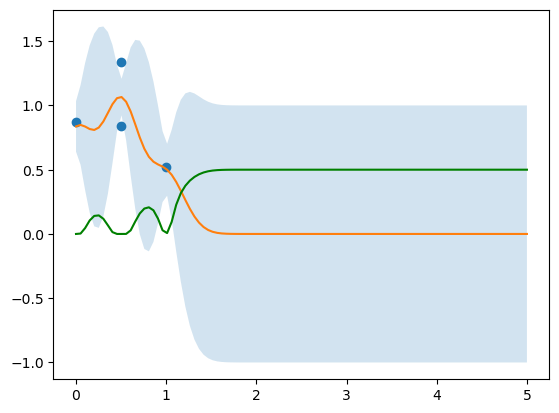

In [156]:
N= 3
O= N//2
X= np.linspace(0,1,N)
X= np.hstack([X, np.array([X[O]])])
Y= np.random.uniform(0,1,N+1)
Y[-1]= Y[O]+0.5
X= X.reshape(-1, 1)

F= gp.GaussianProcessRegressor(
    n_restarts_optimizer=0,
    alpha=0.2**2,
    kernel=
        gp.kernels.ConstantKernel(1.0, constant_value_bounds="fixed") * gp.kernels.RBF(0.2, length_scale_bounds="fixed")
)
F.fit(X, Y)

plt.plot(X, Y, 'o')

X_test= np.linspace(0,5,100).reshape(-1, 1)
Y_test, Y_std= F.predict(X_test, return_std=True)
plt.plot(X_test, Y_test, '-')
plt.fill_between(X_test.flatten(), Y_test.flatten()-Y_std, Y_test.flatten()+Y_std, alpha=0.2)

plt.plot(X_test, stats.norm.cdf(0.0, loc= Y_test, scale= Y_std), c='g')

In [7]:
F_domains = [
    (0.0, 0.2),
    (-0.004, 0.015)
]

sample_size= 1000
rnd = np.random.default_rng(37)
point_set = rnd.uniform(0, 1, size=(sample_size, len(F_domains)))
point_set = np.array([p*(d[1]-d[0])+d[0] for (p,d) in zip(point_set.T, F_domains)]).T

pd.DataFrame(point_set).describe()

,0,1
count,1000.000000,1000.000000
mean,0.097568,0.005799
std,0.056408,0.005530
min,0.000073,-0.003998
25%,0.048737,0.000884
50%,0.099326,0.006350
75%,0.145870,0.010632
max,0.199497,0.014990
